In [2]:
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/')
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/data')
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/rl2')
import torch
from model import RL2, MetaLearner
import torch.nn.utils.rnn as rnn_utils
import numpy as np

In [55]:
datas = pd.read_csv('../data/human/exp1_llm_checkpoint.csv')

/u/ajagadish/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3505: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [62]:
correct = np.ones((4, 10, 96))

for participant_id  in range(10):#= 4
    for cond in datas.condition.unique(): #datas.condition.nunique()):
        data = datas[datas.condition==cond]
        correct_trials = data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values
        correct[cond-1, participant_id,:len(correct_trials)] = correct_trials
        #plt.plot(data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values)

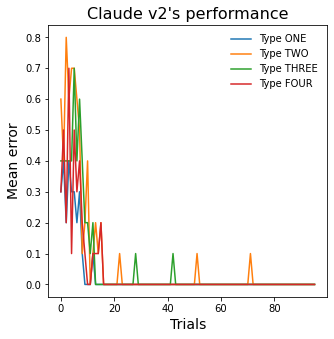

In [63]:
plt.figure(figsize=(5,5))
for cond in range(datas.condition.nunique()):
    plt.plot(1-correct[cond].mean(0), label = ["Type ONE", "Type TWO", "Type THREE", "Type FOUR"][cond])
plt.title("Claude v2's performance", fontsize=16)
plt.xlabel("Trials", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()